In [1]:
from glob import glob
import os, sys

In [2]:
ndvi_images = glob("*_NDVI_MASKED.tif")

ndvi_images

['2013_NDVI_MASKED.tif',
 '2014_NDVI_MASKED.tif',
 '2015_NDVI_MASKED.tif',
 '2016_NDVI_MASKED.tif',
 '2017_NDVI_MASKED.tif',
 '2018_NDVI_MASKED.tif',
 '2019_NDVI_MASKED.tif',
 '2020_NDVI_MASKED.tif',
 '2021_NDVI_MASKED.tif',
 '2022_NDVI_MASKED.tif']

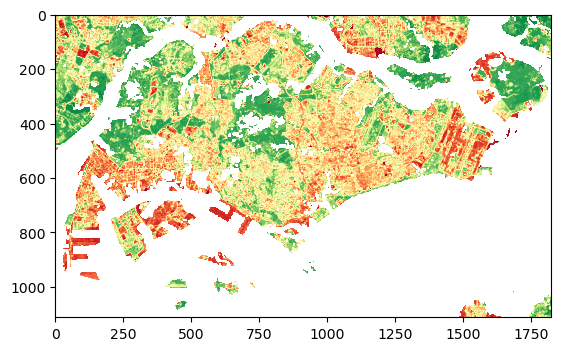

In [3]:
import rasterio as rio
from rasterio.plot import show

with rio.open(ndvi_images[-1]) as src:
    ndvi = src.read()
    profile = src.profile
    src.close()
    
show(ndvi, cmap = "RdYlGn", vmin = 0, vmax = 1);

In [4]:
import geopandas as gpd

sg_suburbs = gpd.read_file("sg_suburbs_cleaned.geojson")

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Threshold NDVI to 0.7
ndvi_threshold = ndvi < 0.5
ndvi_masked = np.ma.masked_array(ndvi, ndvi_threshold)

C:\Users\tranq\anaconda3\envs\gdal_new\Lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Axes: >

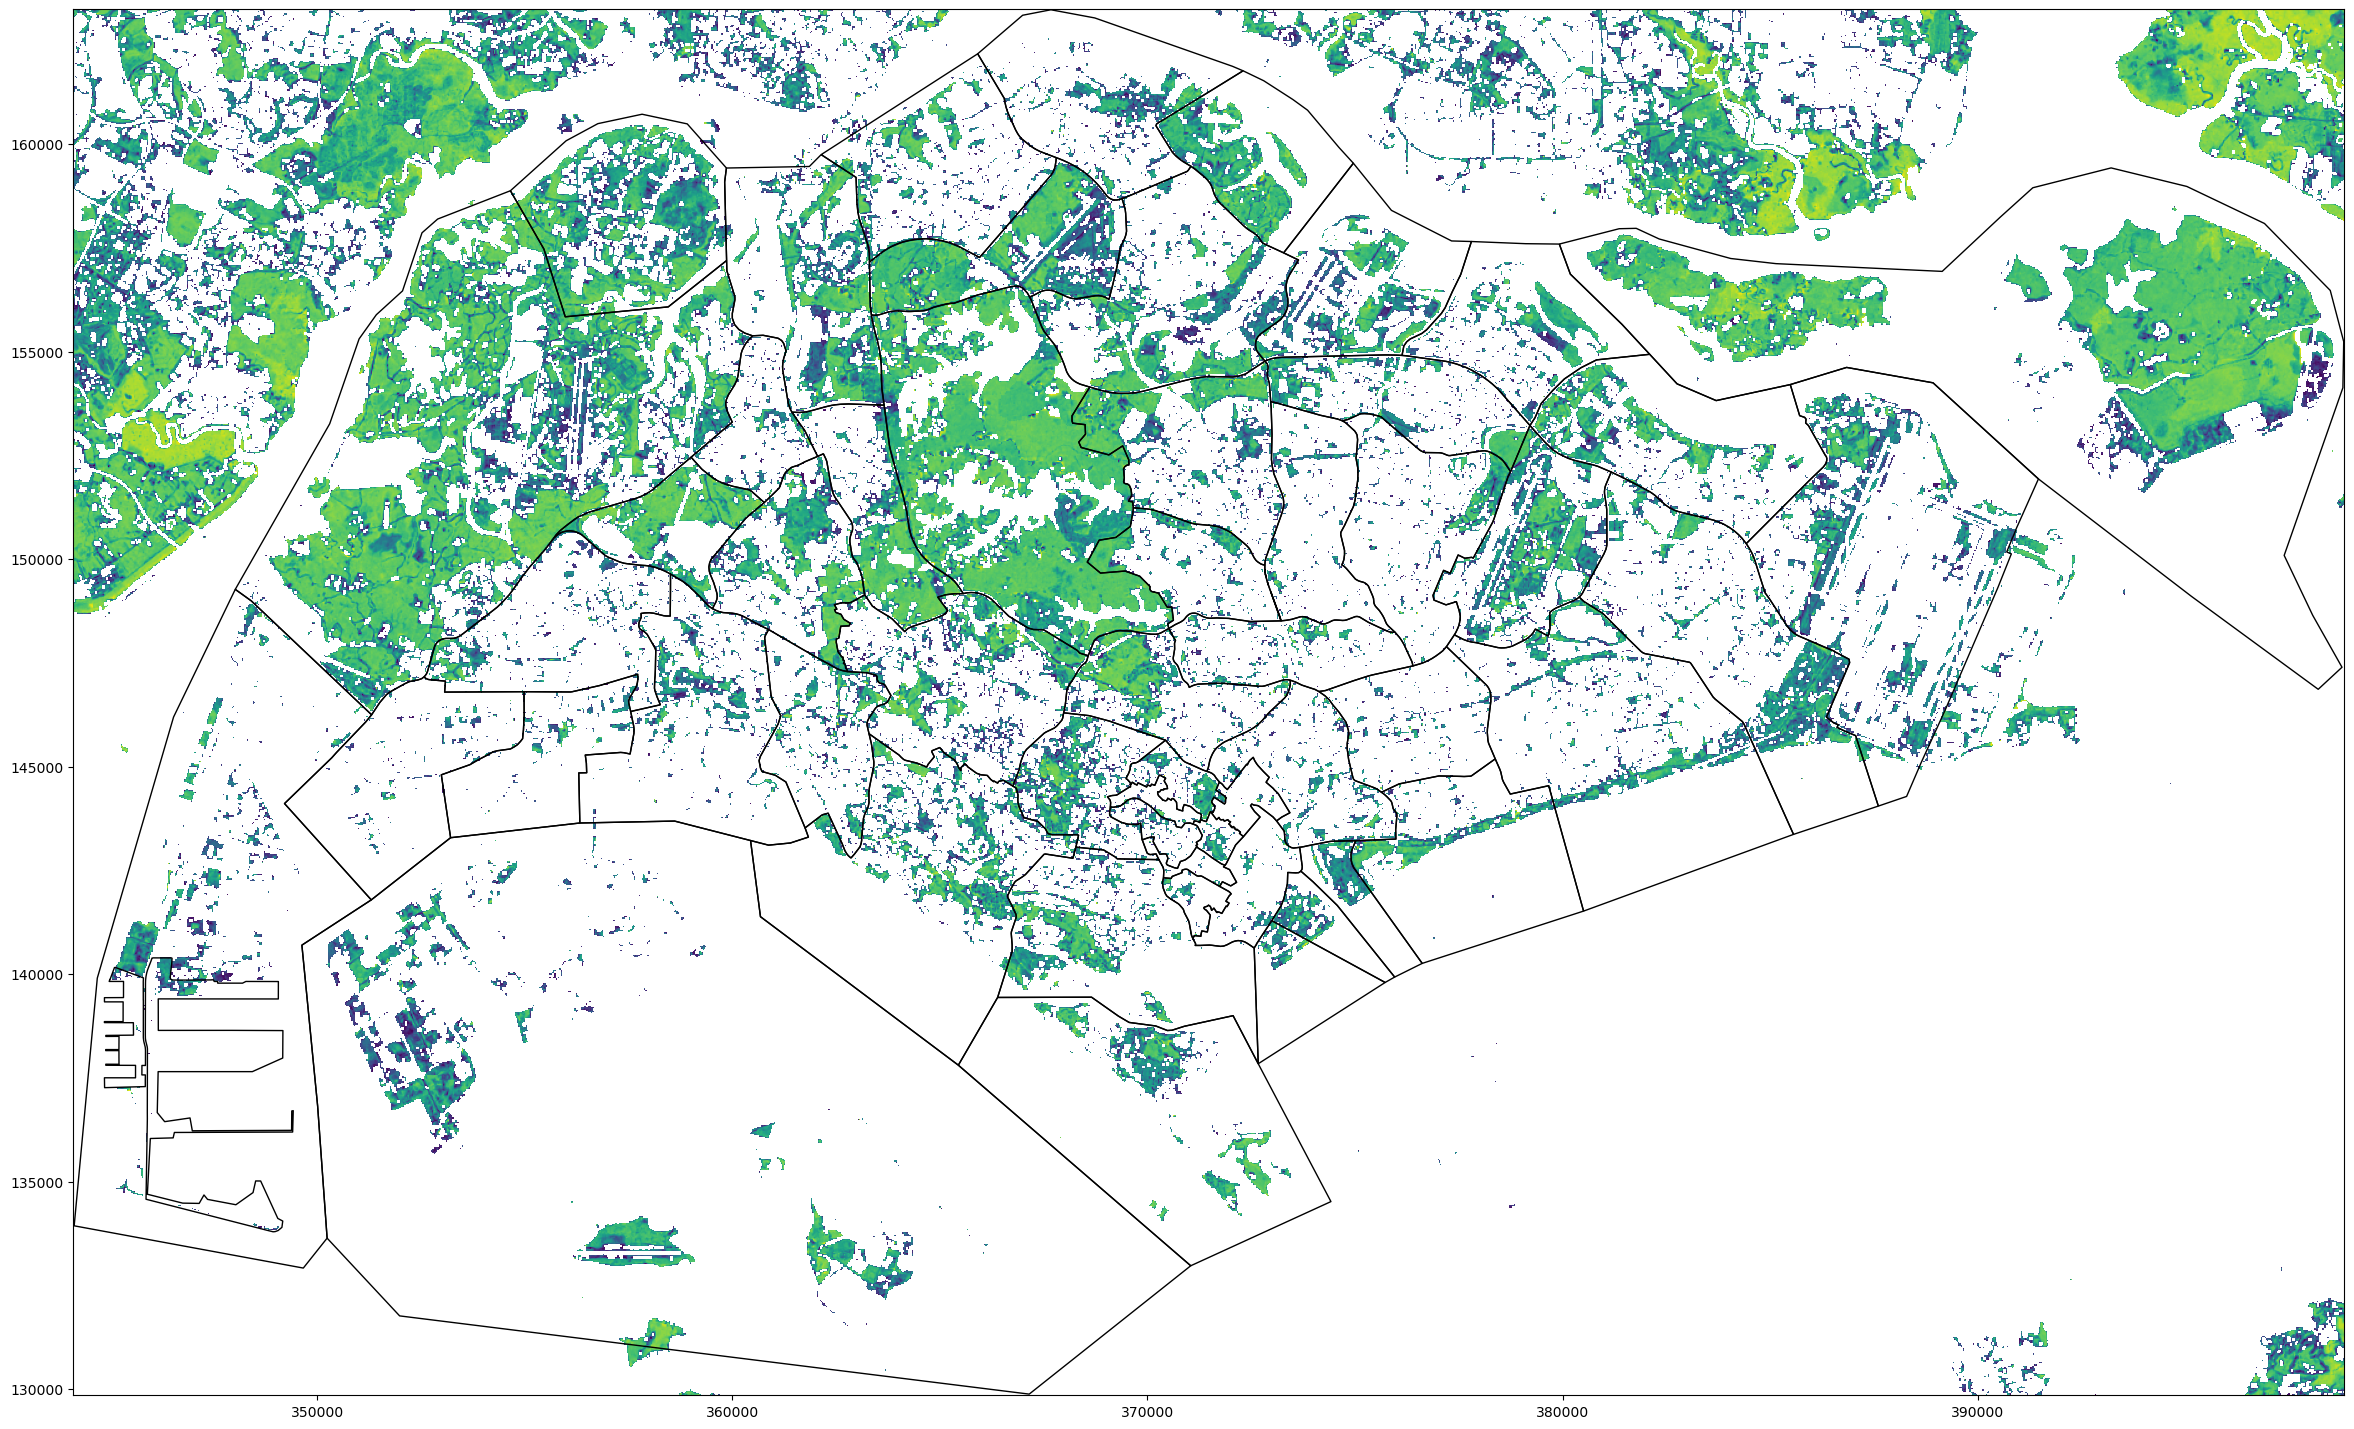

In [6]:
fig, ax = plt.subplots(figsize = (32,18))

show(ndvi_masked, transform = profile["transform"], ax = ax)
sg_suburbs.plot(ax = ax, edgecolor = "black", color = "none")

In [7]:
# calculate the proportion of each administrative region with NDVI > 0.5
with rio.open(ndvi_images[-1]) as src:
    ndvi_prop = src.read()
    profile = src.profile
    src.close()
    
ndvi_prop[ndvi_prop > 0.5] = 1
ndvi_prop[ndvi_prop < 0.5] = 0

ndvi_prop

array([[[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ...,  1.,  1.,  0.],
        [nan, nan, nan, ...,  1.,  1.,  1.],
        [nan, nan, nan, ...,  1.,  1.,  1.]]], dtype=float32)

In [8]:
import rasterstats
import pandas as pd
import numpy as np

cat_map = {0: "Urban", 1: "Healthy Vegetation"}

results = rasterstats.zonal_stats(
    "sg_suburbs_cleaned.geojson",
    ndvi_prop.squeeze(),
    nodata = np.nan,
    affine = profile["transform"],
    categorical = True,
    category_map = cat_map
)

ndvi_df = pd.DataFrame(results)
ndvi_df.head()

Urban  Healthy Vegetation
0   3389                 884
1   5017                7346
2   2773                5492
3  10483                5052
4   4206               14707

In [10]:
# Remember that rasterstats automatically accounts for masked information, so 
# the proportion here does not take into account the area of administrative boundaries that extend
# into the ocean
ndvi_df["prop"] = ndvi_df["Healthy Vegetation"] / ndvi_df.sum(axis = 1)

ndvi_df.head()

Urban  Healthy Vegetation      prop
0   3389                 884  0.206880
1   5017                7346  0.594192
2   2773                5492  0.664489
3  10483                5052  0.325201
4   4206               14707  0.777613

In [11]:
sg_suburbs_ndvi = pd.concat([sg_suburbs, ndvi_df], axis = 1) 

sg_suburbs_ndvi.head()

name                                           geometry  Urban  \
0  Downtown Core  POLYGON ((371740.714 142113.685, 371955.834 14...   3389   
1    Bukit Batok  POLYGON ((362192.747 152536.286, 362055.609 15...   5017   
2         Tengah  POLYGON ((359614.641 149224.902, 359550.156 14...   2773   
3    Jurong West  POLYGON ((358509.535 149245.710, 358510.108 14...  10483   
4   Lim Chu Kang  POLYGON ((359861.582 157191.731, 359814.810 15...   4206   

   Healthy Vegetation      prop  
0                 884  0.206880  
1                7346  0.594192  
2                5492  0.664489  
3                5052  0.325201  
4               14707  0.777613

C:\Users\tranq\anaconda3\envs\gdal_new\Lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'Proportion of Administrative Region with NDVI > 0.5')

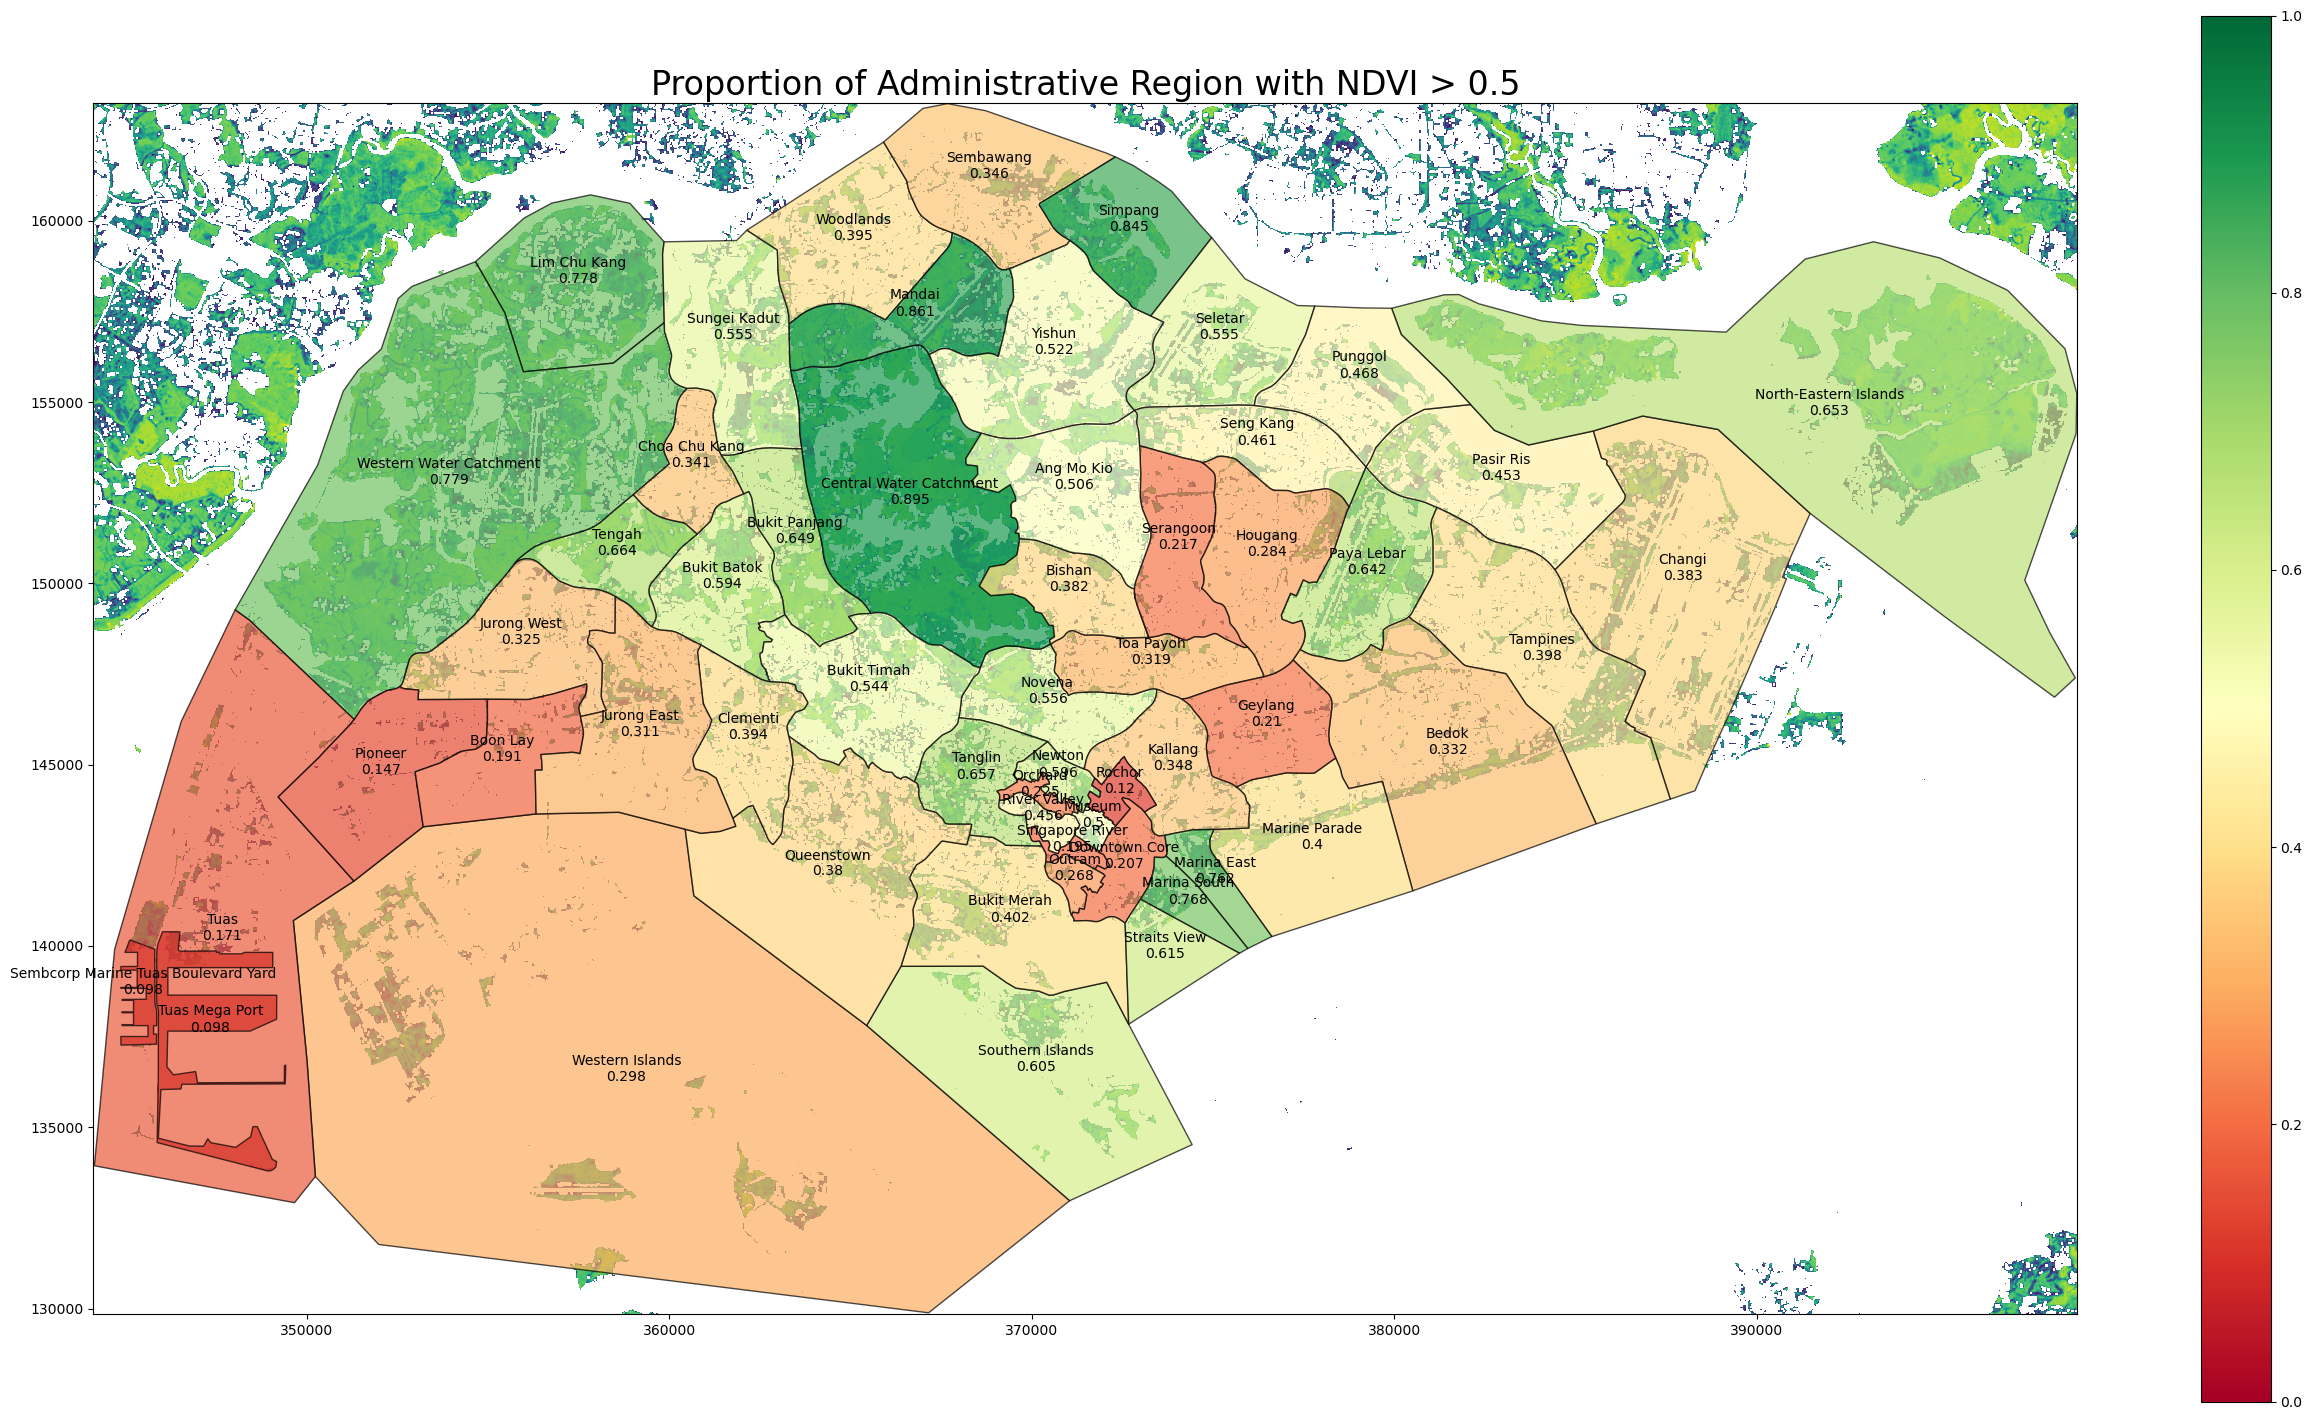

In [26]:
fig, ax = plt.subplots(figsize = (32, 18))

show(ndvi_masked, transform = profile["transform"], ax = ax)
sg_suburbs_ndvi.plot(column = "prop", cmap = "RdYlGn", vmin = 0, vmax = 1, legend = True, 
                    edgecolor = "black", ax = ax, alpha = 0.7)

sg_suburbs_ndvi.apply(lambda x: ax.annotate(
    text = f"{x['name']}\n{round(x['prop'], 3)}", 
    xy = x["geometry"].centroid.coords[0], 
    ha = "center"
), axis = 1);

ax.set_title("Proportion of Administrative Region with NDVI > 0.5", fontsize = 24)

In [17]:
sg_suburbs_ndvi.head()

name                                           geometry  Urban  \
0  Downtown Core  POLYGON ((371740.714 142113.685, 371955.834 14...   3389   
1    Bukit Batok  POLYGON ((362192.747 152536.286, 362055.609 15...   5017   
2         Tengah  POLYGON ((359614.641 149224.902, 359550.156 14...   2773   
3    Jurong West  POLYGON ((358509.535 149245.710, 358510.108 14...  10483   
4   Lim Chu Kang  POLYGON ((359861.582 157191.731, 359814.810 15...   4206   

   Healthy Vegetation      prop  
0                 884  0.206880  
1                7346  0.594192  
2                5492  0.664489  
3                5052  0.325201  
4               14707  0.777613